In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import random
import patsy
import sklearn.linear_model as linear

sns.set(style="whitegrid")

# Regularization


## Background

A few chapters ago, we talked about our herd of cows and the problem of estimating the mean weight. Why are we interested in the mean cow weight? Well, the mean can be used as a model of cow weights and we can use it to estimate the weight of new cows we encounter.

Here's that data again and a calculation of the mean:

In [4]:
cows = pd.DataFrame({"weight": [1466.2, 1486.3, 1478.1, 1574.8, 1521.7, 1499.7, 1517.7, 1495.2, 1426.9, 1491.2, 1468.9, 1479.5,
1465.7, 1543.4, 1477.1, 1447.2, 1476.0, 1495.8, 1466.7, 1508.2, 1491.2, 1473.3, 1456.9, 1434.8, 1547.3, 1502.6, 
1503.9, 1443.3, 1396.1, 1456.3, 1616.7, 1529.3, 1499.7, 1461.3, 1399.8, 1415.2, 1536.5, 1529.1, 1440.6, 1473.7]})

In [5]:
cows.weight.mean()

1484.8475000000003

 We've already seen how using the mean minimizes mean squared error (which, it turns out, is just the variance) and that we can take the square root of that without loss of generality. Then it becomes mean error (which, it turns out, is the standard deviation). The standard deviation is nicer to work with because it's in the units of the problem (pounds in this case) rather than pounds-squared.

In [6]:
cows.weight.std()

44.910771864745094

This is fine as it goes. We can estimate that a cow's weight will be 1484.85 pounds and we should be within about 1.96 of that 95% percent of the time. That is, the cow weights we encounter should be in the range:

$1484 - 1.96 \times 44.91 = 1,395.98$

to

$1484 + 1.96 \times 44.91 = 1,572.02$

95% of the time if the distribution of cow weights is approximately normal ("if the normal distribution is a good model for this data").

Later on, we saw how we could use the Normal distribution itself as a model for cow weights by parameterizing it with values calculated from our data. By using the Normal distribution as a model, we ask more interesting questions rather than just estimate the weight of the next cow:

In [7]:
from scipy.stats import norm

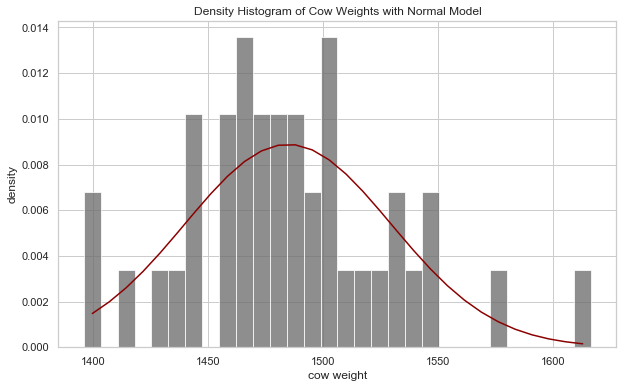

In [8]:
figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1, 1, 1)
n, bins, patches = axes.hist(cows.weight, color="DimGray", density=True,bins=30, alpha=0.75)
axes.set_xlabel( "cow weight")
axes.set_ylabel( "density")
axes.set_title("Density Histogram of Cow Weights with Normal Model")

xs = [(b2 + b1)/2 for b1, b2 in zip(bins, bins[1:])]    

mean = cows.weight.mean()
std  = cows.weight.std()
ys = [norm.pdf( k, loc=mean, scale=std) for k in xs]
axes.plot(xs, ys, color="darkred")

plt.show()
plt.close()

What's the probability that a cow will be under 1400 pounds?

In [9]:
norm.cdf(1400, mean, std)

0.029429430969638553

What's the probability that a cow will weight more than 1500?

In [10]:
1 - norm.cdf(1500, mean, std)

0.3679110021668426

We also saw, in a different chapter, that our data is just a sample from the process that generates cows that we weigh and so the "actual" mean might be something different than what we estimated. In order to generate bounds on our estimate, we simulated resampling from the population by resampling from the sample. This is the Bootstrap. This is not as far fetched as it would seem.

In order to generate Frequentist confidence bounds we know that the standard *error* (the standard deviation of the estimator) for the mean is:

$ se = \frac{\sigma}{\sqrt{n}}$

but we don't have $\sigma$. We don't ever have $\sigma$. But we do have $s$, the *estimate* so we use that. This "Substitution Principle" is used often in statistics. We can use it here. We don't have the population to resample from so we substitute the sample. Based on the Law of Large Numbers and everything else we went through in the chapter on statistical inference, we see that as the sample size increases, the fidelity of this approach increases.

Additionally, if we are willing to use a uniform prior, we can interpret the Bootstrap sampling distribution of means as the posterior distribution. That is, if our prior is $\mu \sim U(-\infty, \infty)$ then the distribution of means created by using the Bootstrap has a Bayesian interpretation without specifying the prior and likelihood formally. As it turns out Frequentist statistics assume a uniform prior as well, it just doesn't result in a posterior distribution. It's more than just a *toe-MAY-toe* versus *toe-MAH-toe* thing. They're fundamentally different views on what statistical inference is.

In [11]:
def resample(data):
    n = len(data)
    return [data[i] for i in [random.randint(0, n - 1) for _ in range( 0, n)]]

In [12]:
mean_weight = np.array([np.mean(data) for data in [resample(cows.weight) for i in range( 0, 10000)]])

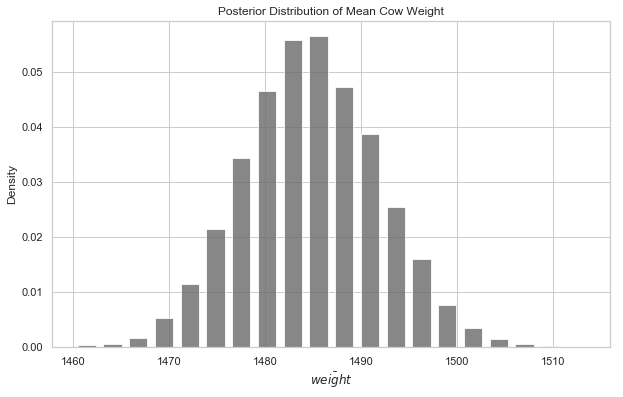

In [13]:
ys, bins = np.histogram(mean_weight, bins=20, density=True)
width = 0.7*(bins[ 1] - bins[ 0])
center = (bins[ :-1]+bins[1:])/2

figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1, 1, 1)

axes.bar( center, ys, align='center', width=width, color="dimgray", alpha=0.8)
#axes.set_xlim([70.0, 80.0])
axes.set_xlabel( r"$\bar{weight}$")
axes.set_ylabel("Density")
axes.set_title( "Posterior Distribution of Mean Cow Weight")

plt.show()
plt.close()

Again, why all this work? 

Remember, the data we collect is consistent with any of a large number of possible means just as the sequence "HHHTH" is consistent with any of a large number of possible biases of a coin. If we're to use the mean as a model, we want to know how plausible each of these possible models is.

You may notice a disconnect between the two things we just did. First, we used the mean and standard deviation of cow weights to model the cow weights and then we turned around and said that we were uncertain about the mean of cow weights! (and standard deviation of cow weights).  You would be right.

We modeled two things:

$\hat{weight} \sim N(\bar{weight}, s)$

and

$P(\mu_{weight}|data) \propto P(data|\mu_{weight})P(\mu_{weight})$

but it's easy to see that they *should* be connected and aren't. We're not using our model of the uncertainty in the mean cow weight inform our model of cow weights. We might call this a first order Bayesian model. But this doesn't mean we *couldn't*...it's just difficult to do.

Formally, our model says that $y$ is Normally distributed with mean $\bar{y}$ and standard deviation, $s$.

$\hat{y} \sim N(\bar{y}, s)$

We can expand on this model by plugging in our uncertainty about $\bar{y}$ and $s$. Now, in Bayesian statistics, we often just drop the "bar" business because we know we're talking about uncertainty over models and not "sample" or "population" parameters. So we can think of our model in terms of distributions and priors:

$\hat{y} \sim N(\mu, \sigma)$

$\mu \sim U(-\infty, \infty)$

$\sigma \sim U(0, \infty)$

This says that our estimate of $y$ is Normally distributed with mean, $\mu$, and standard deviation, $\sigma$, and that our prior for $\mu$ is Uniform from negative infinity to positive infinity. The standard deviation, $\sigma$, is Uniformly distributed from 0 to positive infinity. We definitely can't estimate this model using the Bootstrap; only MCMC methods will work (which are well beyond the scope of these notes). However, we're only interested in the intuition behind this model to explain why regularization is necessary and what it does.

We've always heard that the mean is sensitive to outliers. This is just another way of saying we want the signal, not the noise...and the mean is sensitive to noise. If we think in terms of priors, we can see why: the mean here has a uniform prior. Before looking at the data, our model, a little "robot" if you will, has no preconceptions whatsoever about what the value of the mean should be and therefore it trusts the data completely. As MacElreath says, "it gets excited by the data...it doesn't know any better. It's the only data it's ever seen."

As we did a few chapters ago, let's expand on this idea to include linear regression. What changes to we need to make to turn the model above into linear regression? How about this:

$\hat{y} \sim N(\mu, \sigma)$

$\mu = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_n x_n$

$\beta_i \sim U(-\infty, \infty)$

$\sigma \sim U(0, \infty)$

The big change is for $\mu$ which is now a linear function of the $x_i$s. However, we have literally passed the buck. Each coefficient, $\beta_i$, still has a uniform prior. And so, we can have the same problem, our model may over fit the data.

While you could estimate the above model using MCMC methods, you don't need to do so. It just turns out that it's broadly equivalent to using OLS to estimate the coefficients exactly *and* use the Bootstrap to estimate posteriors with the equivalent priors. As we'll see shortly, we can use direct math to simulate a few different kinds of priors. But first...

...what do we mean when we say that Linear Regression *under* or *over* fits the data?

## Under and Over Fitting with Linear Regression

We start by generating a small data set. This will be the same quadratic data set we used in the Residuals section of the last chapter but with some added noise.

In [14]:
import sys
sys.path.append('resources')
import models

In [15]:
np.random.seed(6734745)

In [16]:
n = 25
x1 = np.array([10*np.random.random() for _ in range(n)])
e = stats.norm.rvs(0, 25, n)
ys = 1.00 + 2.5 * (x1**2) + e
data = pd.DataFrame({"y": ys, "x1": x1})

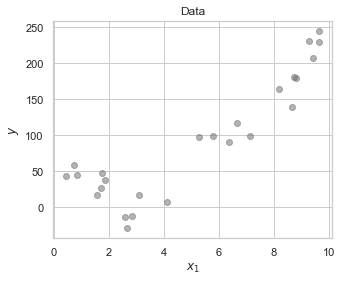

In [17]:
figure = plt.figure(figsize=(5,4))

axes = figure.add_subplot(1, 1, 1)

axes.scatter(data.x1, data.y, color="dimgray", alpha=0.5)
axes.set_title("Data")
axes.set_xlabel(r"$x_1$")
axes.set_ylabel(r"$y$")

plt.show()
plt.close()

What we're going to do is fit this data with a linear regression but with ever higher degree, up to $x^{15}$. Let's first generate our features:

In [18]:
highest_degree = 16

In [19]:
for degree in range(1, highest_degree):
    data["x_" + str(degree)] = data['x1'] ** degree

We start be creating a Mean Squared Error (MSE) calculator that uses the `result` that our functions return. We could just use $R^2$ or $\bar{R}^2$ but we're really interested in maximizing the explanatory power of the model, we're interested in minimizes the estimation error. (Although $\sigma$ is very close to MSE, it's not exactly MSE).

In [20]:
def mse(result):
    sum_squared_errors = np.sum([(y - y_hat)**2 for y, y_hat in zip(result["y"], result["y_hat"])])
    return sum_squared_errors / len(result["y_hat"])

Additionally, while mean scaling (also called *normalization*) was sometimes a good idea in linear regression, it is required for ridge regression. As we'll see in a later chapter, anything that uses a Loss function associated with "squared" should probably be normalized if the algorithm doesn't use exact methods (only OLS uses exact methods).

In [21]:
from sklearn.preprocessing import scale

In [22]:
std_data = pd.DataFrame(scale(data), columns=data.columns)

/Users/stephyn/anaconda3/envs/en685648/lib/python3.7/site-packages/sklearn/preprocessing/data.py:176: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


We get the warning above because some of the values above $x_6$ were so large that when you do the division, they're resolving to identical numbers.

In [23]:
std_data.head()

,y,x1,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,x_11,x_12,x_13,x_14,x_15
0,1.047824,1.143616,1.143616,1.192733,1.175738,1.125106,1.057180,0.980736,0.900651,0.819798,0.739976,0.662359,0.587725,0.516576,0.449216,0.385797,0.326364
1,-1.048669,-0.303046,-0.303046,-0.567222,-0.683544,-0.716441,-0.711513,-0.692305,-0.669291,-0.646594,-0.625568,-0.606466,-0.589157,-0.573414,-0.559016,-0.545779,-0.533554
2,1.672625,1.287074,1.287074,1.436573,1.520713,1.565935,1.586399,1.590280,1.582376,1.565668,1.542163,1.513334,1.480325,1.444065,1.405319,1.364726,1.322817
3,0.556361,1.095635,1.095635,1.113970,1.068142,0.992371,0.903372,0.809777,0.716170,0.625091,0.538005,0.455755,0.378792,0.307308,0.241312,0.180686,0.125227
4,1.396863,1.331347,1.331347,1.514351,1.634421,1.716052,1.772553,1.811707,1.838081,1.854476,1.862756,1.864279,1.860112,1.851131,1.838083,1.821606,1.802249


And then fit our models:

In [24]:
results = []
regressors = []
for degree in range(1, highest_degree):
    regressors.append("x_" + str(degree))
    model = "y ~ " + (" + ".join(regressors))
    result = models.linear_regression(model, std_data)
    results.append(result)

And then plot the models:

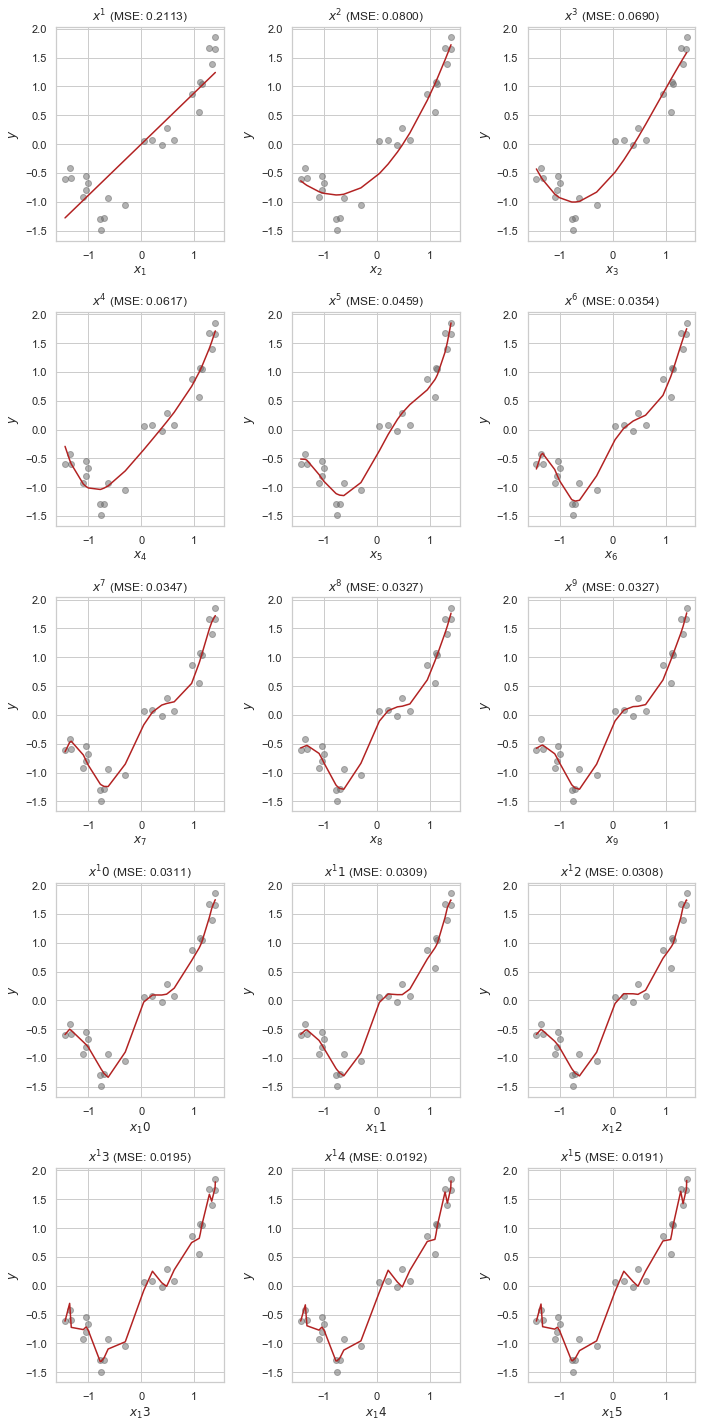

In [25]:
figure = plt.figure(figsize=(10,20))

for degree in range(1, highest_degree):
    axes = figure.add_subplot(5, 3, degree)

    axes.scatter(std_data.x1, std_data.y, color="dimgray", alpha=0.5)
    
    paired = list(zip(std_data.x1, results[degree-1]["y_hat"]))
    paired.sort(key=lambda tup: tup[0])
    x, y = zip(*paired)
    
    axes.plot(x, y, '-', color="firebrick")
    score = mse(results[degree-1])
    axes.set_title(r"$x^{0}$ (MSE: {1:.4f})".format(degree, score))
    axes.set_xlabel(r"$x_{0}$".format(degree))
    axes.set_ylabel(r"$y$")

plt.tight_layout()
plt.show()
plt.close()

As the largest polynomial of our model increases, you can see the model fits the data ever more closely. The sum of squared errors is continually decreasing. However, we also know that most of this "fit" is to noise. We can see the model move from $x_1$ (a high bias -- underfitting-- situation) to $x^{15}$ (a high variance -- overfitting--situation). Mean squared error is steadily decreasing.

Additionally, as the model strives to fit the data ever more closely, as the model becomes more complicated, the sizes of the coefficients start to get larger and larger in absolute value. The table below shows the values as the highest polynomial degree increases for variables $x_1$ through $x_5$:

In [26]:
coefficients = []
for degree in range(1, highest_degree):
    raw = results[degree-1]["coefficients"]
    padded = np.pad(raw, (0, highest_degree - len(raw)), 'constant')
    coefficients.append(padded)
coefficients = np.array(coefficients)
coefficients.transpose()
coefficients = pd.DataFrame(coefficients)
coefficients.columns = list(["x_" + str(d) for d in range(0, highest_degree)])
coefficients[["x_1", "x_2", "x_3", "x_4", "x_5"]]

,x_1,x_2,x_3,x_4,x_5
0,0.888094,0.000000,0.000000,0.000000e+00,0.000000e+00
1,-0.888018,1.812691,0.000000,0.000000e+00,0.000000e+00
2,-2.150847,5.049254,-2.017818,0.000000e+00,0.000000e+00
3,-4.173517,14.656881,-16.389336,6.800198e+00,0.000000e+00
4,2.385817,-29.525894,90.184148,-1.019269e+02,3.980962e+01
5,12.641866,-123.638393,428.769706,-6.817064e+02,5.111526e+02
6,7.763775,-67.255452,158.144925,-1.733569e+01,-3.623828e+02
7,-4.892029,109.504285,-913.855364,3.476713e+03,-6.888480e+03
8,-2.236450,63.395468,-557.659669,1.961898e+03,-3.068438e+03
9,33.987922,-675.836155,6259.354975,-3.337043e+04,1.087216e+05


Neither of these outcomes are desirable. What's to be done?

## L2 Regularization (Ridge Regression)

Regularization involves adding a *penalty* to our Loss function that assigns a cost to coefficients that get overly large. Remember that linear regression itself is:

$\hat{y} = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_n x_n = \sum \beta_i x_i$

then following formula for MSE:

$MSE = \frac{1}{n} \sum (y_i - \hat{y}_i)^2$

and we can substitute one into the other:

$MSE = \frac{1}{n} \sum (y_i - \sum \beta_i x_i)^2$

If we add a penalty, we have:

$MSE = \frac{1}{n} \sum (y_i - \sum \beta_i x_i)^2 + \lambda \sum \beta_i^2$

with $\lambda$ controlling the extent of the penalty starting with no penalty at $\lambda = 0$ and increasing from there. As $\lambda$ increases, the $\beta$s "shrink" (and thus this is often also called "shrinkage"). This is particular formula for regularization goes by the name of Ridge Regression. Because of the square term, it's also called "L2 Regularization". Ridge Regression is controversial in many circles. 

The penalty term causes the coefficient estimates to become biased and Frequentist statistical inference is not possible as a result. However, ridge regression can effectively deal with situations where you have a large number of variables and a lot of multicollinearity. It's just up to you to make sure you only include variables that have a reason for being in the model and that the final model makes sense. I wouldn't use it for a scientific paper, however.

Now, while Ridge Regression has no Frequentist interpretation, it does have a *Bayesian* one, hence the reason for our refresher/detour. The penalty term is equivalent to priors on the coefficients taken from a *Normal* distribution instead of a *Uniform* distribution. Continuing our discussion from above, the mathematical formula we have described is equivalent to the following Bayesian model:

$\hat{y} \sim N(\mu, \sigma)$

$\mu = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_n x_n$

$\beta_i \sim N(0, \sigma_\beta)$

$\sigma \sim HCauchy(\gamma)$

where the prior for each $\beta_i$ is now *Normal*. You control the degree of regularization using $\sigma_\beta$. It turns out that $\sigma_\beta$ is (inversely) related to $\lambda$. ($HCauchy$ is the "Half Cauchy" distribution parameterized by $\gamma$. The Cauchy distribution is generally "bell shaped" but limited to positive numbers in this case). But, again, because the math works out in this case, we're not going to use MCMC, we can use the regular ridge regression formula and pick the best $\lambda$.

Of course, now it's even more confusing because it's not actually $\lambda$ in the `sklearn` library, it's called $\alpha$. Oh, well. We'll call it $\alpha$ from now on. Just know that it's the $\lambda$ in the above equation and this is equivalent to changing $\sigma_{\beta}$ in some Bayesian model.

Let's see what that might look like. Our original prior for $\beta_i$ was $U(\infty, \infty)$. That is the dark horizontal line below. Our new prior for $\beta_i$ is $N(0, \sigma_{\beta}$ (or just $\sigma$ for now).

We have plotted a few different versions of this prior. You can see that large values of $\sigma$ (small values of $\alpha$) lead to very wide, weaker priors for $\beta_i$ and very small values of $\sigma$ (large values of $\alpha$) lead to very narrow, strong priors for $\beta_i$.

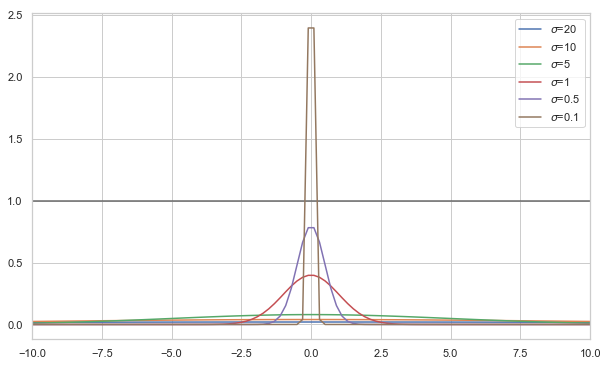

In [27]:
figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1, 1, 1)
axes.set_xlim((-10, 10))
axes.axhline(y=1, xmin=-10, xmax=10, color="dimgray")

xs = np.linspace(-10, 10, 100)

for std in [20, 10, 5, 1, 0.5, 0.1]:
    ys = [norm.pdf( k, loc=0, scale=std) for k in xs]
    axes.plot(xs, ys, label=r"$\sigma$=" + str(std))

axes.legend()
plt.show()
plt.close()

Let's reproduce our chart of regression results from above, using the full 15 feature model, but different values of $\alpha$. We will run a Ridge regression for each value of $\alpha$ and then plot it just as we did before.

In [28]:
results = []
alphas = [1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
model = "y ~ " + (" + ".join(regressors))
for alpha in alphas:
    result = models.linear_regression(model, std_data, style="ridge", params={"alpha": alpha})
    results.append(result)

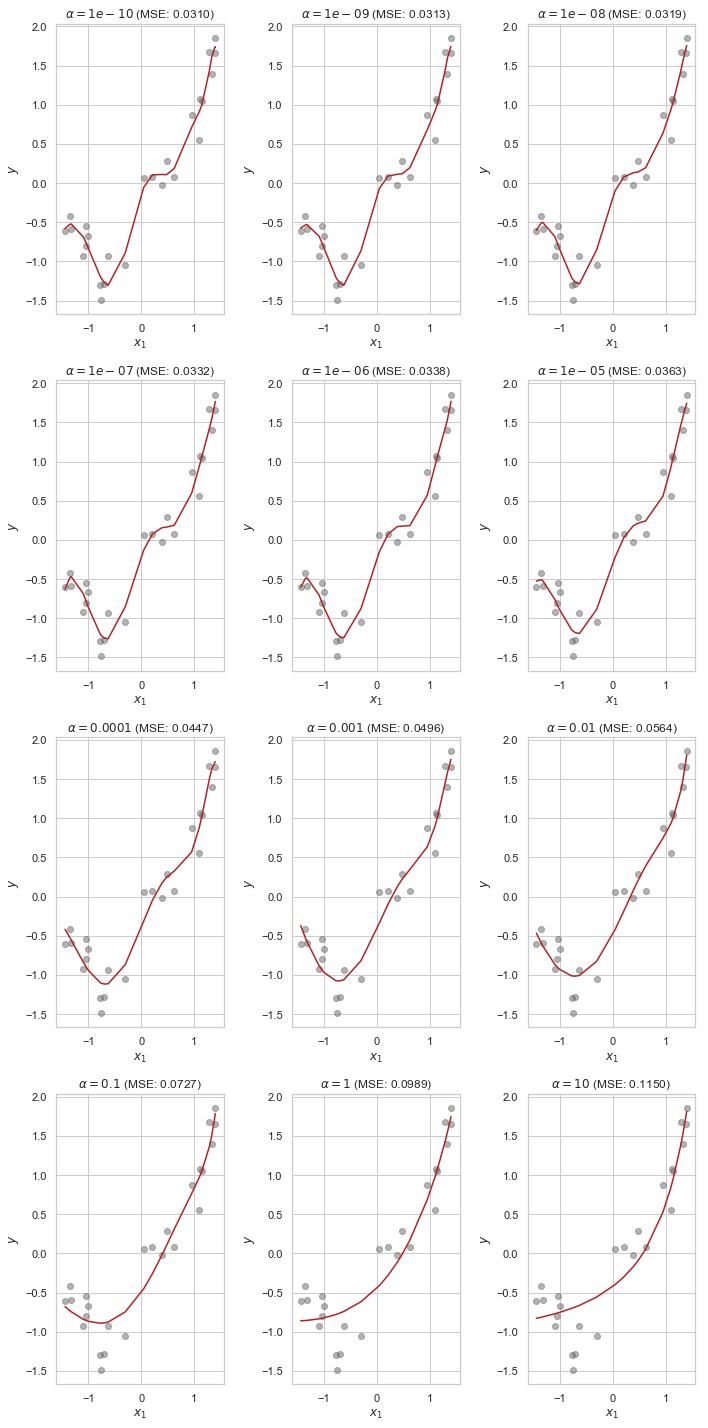

In [29]:
figure = plt.figure(figsize=(10,20))

for i, alpha in enumerate(alphas):
    axes = figure.add_subplot(4, 3, i + 1)

    axes.scatter(std_data.x1, std_data.y, color="dimgray", alpha=0.5)
    
    paired = list(zip(std_data.x1, results[i]["y_hat"]))
    paired.sort(key=lambda tup: tup[0])
    x, y = zip(*paired)
    
    axes.plot(x, y, '-', color="firebrick")
    score = mse(results[i])
    axes.set_title(r"$\alpha={0}$ (MSE: {1:.4f})".format(alpha, score))
    axes.set_xlabel(r"$x_1$")
    axes.set_ylabel(r"$y$")

plt.tight_layout()
plt.show()
plt.close()

Here we can see that as the value of $\alpha$ increases, the model is more "regularized". In Bayesian terms, this is because our prior that each $\beta_i$ is actually 0 is increasingly strong. The MSE is not as low with regularization. We'll need to perform cross validation to pick a proper $\alpha$ (or validation curves).

So how do we pick $\alpha$?

One way suggested by many is to use a "coefficient trace". The Coefficient Trace runs a specific model for a wide range of $\alpha$s. This helps you see for your specific model and data, where and what values of $\alpha$ will force the coefficients to zero.

You are supposed to pick the value of $\alpha$ for which the coefficients are stable.

In [30]:
n_alphas = 200
alphas = np.logspace(-10, -2, n_alphas)
model = "y ~ " + (" + ".join(regressors))
coefficients = []
for alpha in alphas:
    result = models.linear_regression(model, std_data, style="ridge", params={"alpha": alpha})
    coefficients.append(result["coefficients"])
coefficients = np.array(coefficients)
coefficients = coefficients.transpose()

Here is the Coefficient Trace. You will sometimes see the x-axis reversed in a Coefficient Trace so be aware of that. It's very difficult to know in advance what a range of values will do so you may have to resort to trail and error. We started with (log) values of $\alpha$ from -10 to 10 and then saw that we could cut down the upper range to 2.

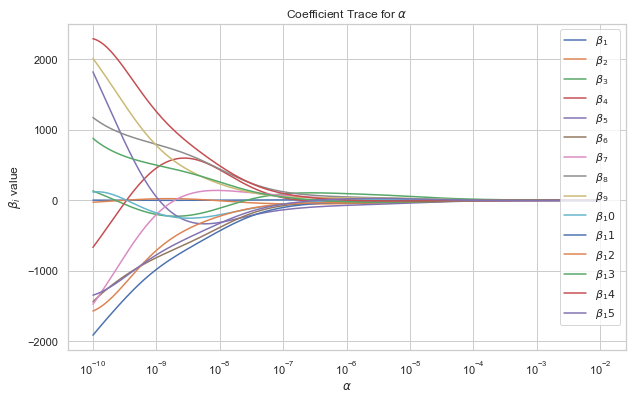

In [31]:
figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1, 1, 1)

for i in range(1, len(coefficients)):
    axes.plot(alphas, coefficients[i], '-', label=r"$\beta_{0}$".format(i))
axes.legend(loc=1)
axes.set_xscale('log')
axes.set_title( r"Coefficient Trace for $\alpha$")
axes.set_ylabel(r"$\beta_i$ value")
axes.set_xlabel(r"$\alpha$")

plt.show()
plt.close()

The plot is interesting although difficult to read. Some coefficients go from positive to negative. Still they don't have quite the same instability we saw in the case of the unregularized regression.

Remember that the advice from the previous sections is that we only apply regularization in a high *variance* situation where we are overfitting. Unfortunately, we don't have a large enough data set here to plot learning curves to determine if we are in a high bias or high variance situation. If regularization is indicated, then we would plot validation curves to pick the best $\alpha$.

## L1 Regularization (Lasso Regression)

Ridge regression uses "L2 regularization". The "L2" describes the form of the penalty:

$+ \lambda \sum \beta_i^2$

and refers to the *L2 norm*. It follows that other penalties are possible, for example, if we use the *L1 norm*:

$+ \lambda \sum |\beta_i|$

or absolute value instead of square. Now we seek to minimize the following Loss as MSE:

$MSE = \frac{1}{n} \sum (y_i - \sum \beta_i x_i)^2 + \lambda \sum |\beta_i|$

In Bayesian terms, this is an even stronger prior on $\beta_i$ (i > 0) to be zero because it is equivalent to a Laplace distribution as a prior instead of the Normal distribution:

$\hat{y} \sim N(\mu, \sigma)$

$\mu = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_n x_n$

$\beta_i \sim Laplace(0, b)$

$\sigma \sim HCauchy(\gamma)$

with $Laplace()$ replacing $N()$. The Laplace distribution is also called the "double exponential" distribution and is parameterized by $\mu$ and $b$.

The plot below compares our previous priors (dark, Uniform; blue, Normal) and various Laplace distributions.

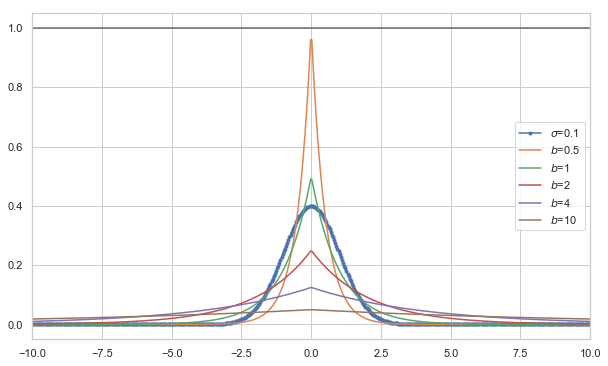

In [32]:
figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1, 1, 1)
axes.set_xlim((-10, 10))
axes.axhline(y=1, xmin=-10, xmax=10, color="dimgray")

xs = np.linspace(-10, 10, 500)

ys = [norm.pdf( k, loc=0, scale=1) for k in xs]
axes.plot(xs, ys, marker=".", label=r"$\sigma$=" + str(std))

for b in [0.5, 1, 2, 4, 10]:
    ys = [stats.laplace.pdf( k, loc=0, scale=b) for k in xs]
    axes.plot(xs, ys, label=r"$b$=" + str(b))

axes.legend()
plt.show()
plt.close()

In [33]:
results = []
alphas = [0.0001, 0.001, 0.01, 0.1, 1]
model = "y ~ " + (" + ".join(regressors))
for alpha in alphas:
    result = models.linear_regression(model, std_data, style="lasso", params={"alpha": alpha, "max_iter": 100000})
    results.append(result)

/Users/stephyn/anaconda3/envs/en685648/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


As you can see above, we can't try out as many values of $\alpha$ on this problem without the algorithm complaining.

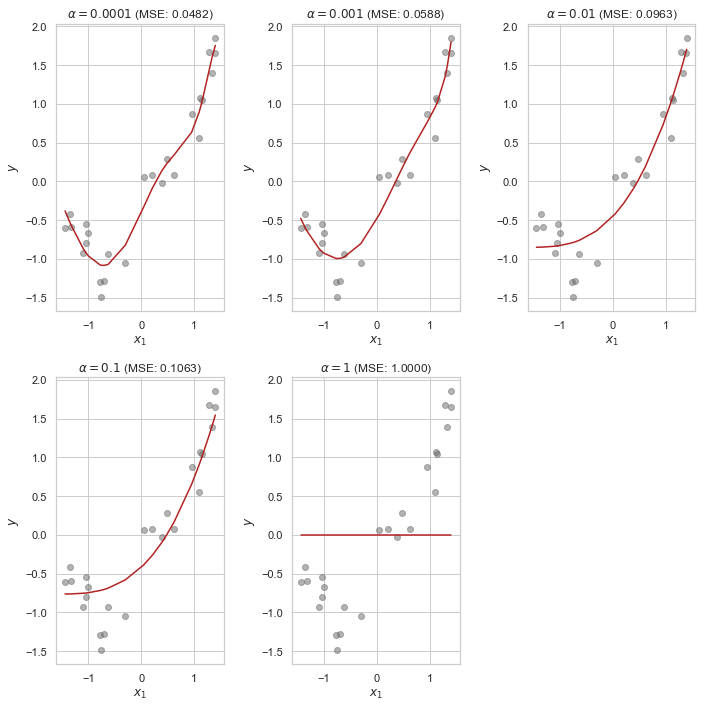

In [34]:
figure = plt.figure(figsize=(10,10))

for i, alpha in enumerate(alphas):
    axes = figure.add_subplot(2, 3, i + 1)

    axes.scatter(std_data.x1, std_data.y, color="dimgray", alpha=0.5)
    
    paired = list(zip(std_data.x1, results[i]["y_hat"]))
    paired.sort(key=lambda tup: tup[0])
    x, y = zip(*paired)
    
    axes.plot(x, y, '-', color="firebrick")
    score = mse(results[i])
    axes.set_title(r"$\alpha={0}$ (MSE: {1:.4f})".format(alpha, score))
    axes.set_xlabel(r"$x_1$")
    axes.set_ylabel(r"$y$")

plt.tight_layout()
plt.show()
plt.close()

We can see values for MSE very near to the ones we saw for Ridge regression. The difference is apparent when we look at the coefficients:

In [35]:
n_alphas = 200
alphas = np.logspace(-3, 2, n_alphas)
model = "y ~ " + (" + ".join(regressors))
coefficients = []
for alpha in alphas:
    result = models.linear_regression(model, std_data, style="lasso", params={"alpha": alpha, "max_iter": 10000})
    coefficients.append(result["coefficients"])
coefficients = np.array(coefficients)
coefficients = coefficients.transpose()

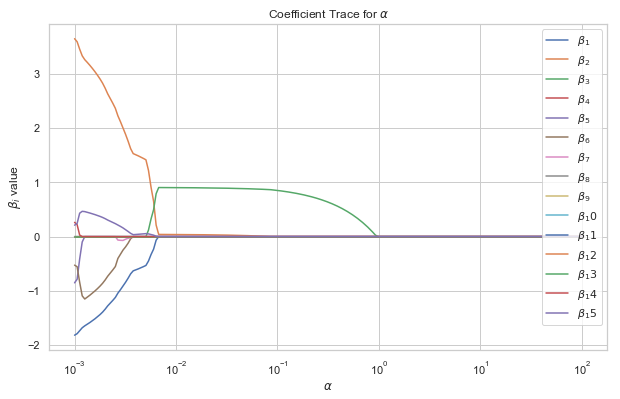

In [36]:
figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1, 1, 1)

for i in range(1, len(coefficients)):
    axes.plot(alphas, coefficients[i], '-', label=r"$\beta_{0}$".format(i))
axes.legend(loc=1)
axes.set_xscale('log')
axes.set_title( r"Coefficient Trace for $\alpha$")
axes.set_ylabel(r"$\beta_i$ value")
axes.set_xlabel(r"$\alpha$")

plt.show()
plt.close()

This Coefficient Trace is a bit more mysterious. It helps to know that as $\alpha$ increases, regularization increases...the prior that $\beta_i$ is zero, increases. With Lasso regression, many coefficients might never be positive. With $\alpha=0.0001$, we have the following coefficients:

In [37]:
results[0]["coefficients"]

array([-0.        , -1.6974969 ,  0.        ,  8.85267356, -0.        ,
       -9.54909241, -0.88200971, -0.        ,  0.        ,  1.47490975,
        4.00180265,  0.74292205,  0.        ,  0.        , -0.        ,
       -2.04980358])

We get a MSE of 0.0482 with just 8 of 15 variables. For $\alpha=0.001$, we have:

In [38]:
results[1]["coefficients"]

array([-0.        , -1.81863726,  3.64914011,  0.        , -0.        ,
       -0.85280364, -0.52645195, -0.        , -0.        , -0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.26241618,
        0.21004653])

a MSE of 0.0588 with just 6 of 15 variables. Finally, when $\alpha = 1$, we have a MSE of 0.1063 but we're only using:

In [39]:
results[3]["coefficients"]

array([0.        , 0.        , 0.        , 0.85065207, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        ])

*one* variable...$x_4$.

## Conclusion

There are many different goals with regularization and it depends on the model and how many features you have. If you have a many features and you use Linear Regression as your model, you may have problems with multicollinearity. In that case, you may consider using Ridge or Lasso Regression. If you have more features than observations, you *cannot* use Linear Regression and you should try Lasso Regression. 

Between, Lasso and Ridge regression, if you have a lot of features and you want to make sure some of them are included, you should use Ridge regression. Lasso regression is not stable in the sense that it may not result in the same model every time. For example, if $x_1$ and $x_2$ are correlated, then Lasso regression may put $x_1$ in the model during one run and $x_2$ in the model in the next run.

However, pick the regularization parameter can be tricky and you can rely on Coefficient Traces and Validation Curves to guide you (although they will not always give you a definitive answer).

From a Frequentist perspective, you lose all statistical inference when you move from Linear regression to Lasso or Ridge regression. However, we have shown that the *math* of Ridge or Lasso regression is equivalent to several Bayesian models and that the penalty can be interpreted as a prior on the $\beta$s. If you want even more control over your model, you may want to look into a MCMC model.

There is some discussion as to whether or not you can use Bootstrap estimates for credible intervals for the coefficients. It seems you can as long as you keep the Bayesian interpretation and remember that you have an (implicit) prior in $\alpha$ that the value of each coefficient is zero. The results of a Bayesian inference are always "given the data and the prior". When we assume a uniform prior, we can sometimes leave off the "and the prior". In this case, we could not.

There are other kinds of regularization including a combination of the Ridge and Lasso penalties. The resulting regression is called "Elastic Net". The penalty is:

$+ (1-\alpha) \sum |\beta_i| + \alpha \sum \beta_i^2$

This means that there is always *some* regularization and that the parameter $\alpha$ controls how relative strength of each type of regularization.

Regularization can be applied to logistic regression as well and depends on support from the library you're using. As it turns out, `sklearn` uses L2 regularization by default. You can change it to L1 (Lasso).